## Data Processing

In [34]:
SEQ_LEN_IN = 128
SEQ_LEN_OUT = 5
NUM_FEATURES_IN = 121
NUM_FEATURES_OUT = 121
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
BATCH_SIZE = 128
EPOCHS = 1000
PATIENCE = 15

In [35]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load
import keras
from sklearn.model_selection import train_test_split

In [36]:
def create_sequences_for_seq2seq(data, seq_len_in, seq_len_out, train_size=0.7, val_size=0.15):
    X_enc, y = [], []

    for i in range(len(data) - (seq_len_in + seq_len_out) + 1):
        X_enc.append(data[i : i + seq_len_in])
        y.append(data[i + seq_len_in : i + seq_len_in + seq_len_out])

    X_enc = np.array(X_enc)
    y = np.array(y)

    X_dec = y

    total_samples = len(X_enc)
    train_end = int(total_samples * train_size)
    val_end = int(total_samples * (train_size + val_size))

    X_train_enc, y_train = X_enc[:train_end], y[:train_end]
    X_val_enc, y_val = X_enc[train_end:val_end], y[train_end:val_end]
    X_test_enc, y_test = X_enc[val_end:], y[val_end:]

    X_train_dec = X_dec[:train_end]
    X_val_dec = X_dec[train_end:val_end]
    X_test_dec = X_dec[val_end:]

    return (
        X_train_enc, X_val_enc, X_test_enc,
        X_train_dec, X_val_dec, X_test_dec,
        y_train, y_val, y_test
    )

In [37]:
BLOCK_SIZE = 64

N_BINS_SOH = 5

print("--- Fase 1: Caricamento e preparazione dei dati ---")
files = glob.glob("curves/cell*.csv")
dataframes = []
for path in files:
    cell = os.path.basename(path).split('.')[0]
    df = pd.read_csv(path)
    df.drop(columns=[col for col in df.columns if col.startswith('f_')], inplace=True)
    df.drop(columns=["id", "temperature", "soc", "cell"], errors='ignore', inplace=True)
    df['Cell'] = cell
    dataframes.append(df)
df_all = pd.concat(dataframes, ignore_index=True)
feature_cols = [col for col in df_all.columns if col != 'Cell']




print(f"\n--- Fase 2: Creazione di blocchi (dimensione: {BLOCK_SIZE} cicli) ---")

X_enc_blocks, X_dec_blocks, y_blocks = [], [], []
cell_id_per_block = []
soh_avg_per_block = []

scalers_per_cell = {}

def create_all_sequences(data, seq_len_in, seq_len_out):
    """
    Ritorna (X_enc, X_dec, y) per seq2seq con teacher forcing corretto.
      - X_enc: (N, seq_len_in, n_feat_in)
      - X_dec: (N, seq_len_out, n_feat_out) = y shiftato a destra di 1 (primo token = 0)
      - y    : (N, seq_len_out, n_feat_out)
    """
    X_enc, X_dec, y = [], [], []

    T = len(data)
    win = seq_len_in + seq_len_out
    if T < win:
        return None, None, None

    for i in range(T - win + 1):
        enc_seq = data[i : i + seq_len_in]
        target  = data[i + seq_len_in : i + seq_len_in + seq_len_out]

        dec_in = np.zeros_like(target)
        dec_in[1:] = target[:-1]

        X_enc.append(enc_seq)
        X_dec.append(dec_in)
        y.append(target)

    X_enc = np.array(X_enc)
    X_dec = np.array(X_dec)
    y     = np.array(y)
    return X_enc, X_dec, y


for cell_id, group in df_all.groupby('Cell'):
    print(f"Processando cella: {cell_id}")
    scaler = StandardScaler()
    data_to_scale = group[feature_cols].values
    
    if len(data_to_scale) < SEQ_LEN_IN + SEQ_LEN_OUT:
        print(f"  -> Dati insufficienti per {cell_id}. Saltato.")
        continue
        
    data_cell_scaled = scaler.fit_transform(data_to_scale)
    scalers_per_cell[cell_id] = scaler

    X_enc_cell, X_dec_cell, y_cell = create_all_sequences(data_cell_scaled, SEQ_LEN_IN, SEQ_LEN_OUT)
    if X_enc_cell is None:
        continue

    num_sequences_in_cell = len(X_enc_cell)
    for i in range(0, num_sequences_in_cell, BLOCK_SIZE):
        start_idx = i
        end_idx = i + BLOCK_SIZE
        
        if end_idx > num_sequences_in_cell:
            continue

        X_enc_blocks.append(X_enc_cell[start_idx:end_idx])
        X_dec_blocks.append(X_dec_cell[start_idx:end_idx])
        y_blocks.append(y_cell[start_idx:end_idx])
        
        cell_id_per_block.append(cell_id)
        soh_avg_per_block.append(np.mean(y_cell[start_idx:end_idx, :, -1]))

dump(scalers_per_cell, 'scalers_per_cell.joblib')
print(f"Creati {len(X_enc_blocks)} blocchi totali.")

print("\n--- Fase 3: Esecuzione dello split stratificato sui blocchi ---")

block_indices = np.arange(len(X_enc_blocks))

soh_bins = pd.cut(soh_avg_per_block, bins=N_BINS_SOH, labels=False)

train_val_indices, test_indices = train_test_split(
    block_indices,
    test_size=(1 - TRAIN_SPLIT - VAL_SPLIT), 
    stratify=soh_bins,
    random_state=42
)

soh_bins_train_val = soh_bins[train_val_indices]
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=VAL_SPLIT / (TRAIN_SPLIT + VAL_SPLIT),
    stratify=soh_bins_train_val,
    random_state=42
)

print("\n--- Fase 4: Costruzione dei set di training, validazione e test ---")

def build_dataset_from_blocks(indices, x_enc_b, x_dec_b, y_b, cell_ids_b):
    if len(indices) == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])
    
    X_enc = np.concatenate([x_enc_b[i] for i in indices], axis=0)
    X_dec = np.concatenate([x_dec_b[i] for i in indices], axis=0)
    y = np.concatenate([y_b[i] for i in indices], axis=0)
    
    cell_ids_list = []
    for i in indices:
        cell_ids_list.extend([cell_ids_b[i]] * len(y_b[i]))
    
    return X_enc, X_dec, y, np.array(cell_ids_list)

X_train_enc, X_train_dec, y_train, cell_ids_train = build_dataset_from_blocks(train_indices, X_enc_blocks, X_dec_blocks, y_blocks, cell_id_per_block)
X_val_enc, X_val_dec, y_val, cell_ids_val = build_dataset_from_blocks(val_indices, X_enc_blocks, X_dec_blocks, y_blocks, cell_id_per_block)
X_test_enc, X_test_dec, y_test, cell_ids_test = build_dataset_from_blocks(test_indices, X_enc_blocks, X_dec_blocks, y_blocks, cell_id_per_block)

print("\n--- Fase 5: Mescolamento delle sequenze all'interno dei set ---\n")

def shuffle_sets(*arrays):
    if not all(len(arr) > 0 for arr in arrays):
        return arrays
    idx = np.random.permutation(len(arrays[0]))
    return [arr[idx] for arr in arrays]

X_train_enc, X_train_dec, y_train, cell_ids_train = shuffle_sets(X_train_enc, X_train_dec, y_train, cell_ids_train)
X_val_enc, X_val_dec, y_val, cell_ids_val = shuffle_sets(X_val_enc, X_val_dec, y_val, cell_ids_val)
#X_test_enc, X_test_dec, y_test, cell_ids_test = shuffle_sets(X_test_enc, X_test_dec, y_test, cell_ids_test)

print(f"Forma finale X_train_enc: {X_train_enc.shape}")
print(f"Forma finale y_train: {y_train.shape}")
print(f"Forma finale X_val_enc: {X_val_enc.shape}")
print(f"Forma finale y_val: {y_val.shape}")
print(f"Forma X_test_enc (prima dell'ordinamento): {X_test_enc.shape}")
print(f"Forma y_test (prima dell'ordinamento): {y_test.shape}")
print(f"Forma cell_ids_test (prima dell'ordinamento): {cell_ids_test.shape}")


print("Test set ordinato con successo.")
print("\nVerifica dell'ordinamento:")
print(f"Primi 10 ID cella nel test set ordinato: {cell_ids_test[:10]}")
print(f"Ultimi 10 ID cella nel test set ordinato: {cell_ids_test[-10:]}")

--- Fase 1: Caricamento e preparazione dei dati ---

--- Fase 2: Creazione di blocchi (dimensione: 64 cicli) ---
Processando cella: cell_1_good
Processando cella: cell_2_good
Processando cella: cell_5_good
Creati 91 blocchi totali.

--- Fase 3: Esecuzione dello split stratificato sui blocchi ---

--- Fase 4: Costruzione dei set di training, validazione e test ---

--- Fase 5: Mescolamento delle sequenze all'interno dei set ---

Forma finale X_train_enc: (4032, 128, 121)
Forma finale y_train: (4032, 5, 121)
Forma finale X_val_enc: (896, 128, 121)
Forma finale y_val: (896, 5, 121)
Forma X_test_enc (prima dell'ordinamento): (896, 128, 121)
Forma y_test (prima dell'ordinamento): (896, 5, 121)
Forma cell_ids_test (prima dell'ordinamento): (896,)
Test set ordinato con successo.

Verifica dell'ordinamento:
Primi 10 ID cella nel test set ordinato: ['cell_2_good' 'cell_2_good' 'cell_2_good' 'cell_2_good' 'cell_2_good'
 'cell_2_good' 'cell_2_good' 'cell_2_good' 'cell_2_good' 'cell_2_good']
Ultim

In [38]:
def complex_mse_loss(y_true, y_pred):
    """
    Calcola l'errore quadratico medio sul piano complesso.
    Questo forza il modello a imparare la relazione tra parte reale e immaginaria.
    """

    r_idx = tf.constant(list(range(0, 118, 2)))
    i_idx = tf.constant(list(range(1, 118, 2)))

    # tf.gather permette di selezionare colonne specifiche da un tensore
    re_true = tf.gather(y_true, r_idx, axis=-1)
    im_true = tf.gather(y_true, i_idx, axis=-1)

    re_pred = tf.gather(y_pred, r_idx, axis=-1)
    im_pred = tf.gather(y_pred, i_idx, axis=-1)

    z_true = tf.complex(re_true, im_true)
    z_pred = tf.complex(re_pred, im_pred)

    error = tf.abs(z_true - z_pred)
    complex_mse = tf.reduce_mean(tf.square(error))

    return complex_mse

In [39]:
def combined_loss(y_true, y_pred):
    # Pesi per le diverse componenti della loss
    alpha = 10.0  # Peso per la loss complessa
    beta = 1.0   # Peso per la loss sulla temperatura
    gamma = 1.0  # Peso per la loss su SOH

    complex_loss = complex_mse_loss(y_true, y_pred)

    #temp_true = y_true[:, :, -2]
    soh_true = y_true[:, :, -1]
    #temp_pred = y_pred[:, :, -2]
    soh_pred = y_pred[:, :, -1]

    #temp_mse = tf.reduce_mean(tf.square(temp_true - temp_pred))
    soh_mse = tf.reduce_mean(tf.square(soh_true - soh_pred))

    total_loss = (alpha * complex_loss) + (gamma * soh_mse)
    return total_loss

In [40]:
@keras.saving.register_keras_serializable()
class EncoderDecoderTransformer(tf.keras.Model):
    def __init__(self, 
                 seq_len_in, seq_len_out, 
                 num_features_in, num_features_out,
                 d_model=64, num_heads=4, ff_dim=128,
                 num_encoder_layers=4, num_decoder_layers=4,
                 dropout=0.1, **kwargs):
        super().__init__(**kwargs)

        # --- Parametri principali ---
        self.seq_len_in = seq_len_in
        self.seq_len_out = seq_len_out
        self.num_features_in = num_features_in
        self.num_features_out = num_features_out
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dropout = dropout

        # --- ENCODER ---
        self.encoder_input_proj = layers.Dense(d_model)
        # positional embedding fino a seq_len_in (128), ma funziona anche se <128
        self.encoder_pos_embedding = layers.Embedding(input_dim=seq_len_in, output_dim=d_model)

        self.encoder_layers = [
            (
                layers.LayerNormalization(epsilon=1e-6),
                layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout),
                layers.Dropout(dropout),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Dense(ff_dim, activation='relu'),
                layers.Dense(d_model),
                layers.Dropout(dropout)
            ) for _ in range(num_encoder_layers)
        ]

        # --- DECODER ---
        self.decoder_input_proj = layers.Dense(d_model)
        # positional embedding fino a seq_len_out (10)
        self.decoder_pos_embedding = layers.Embedding(input_dim=seq_len_out, output_dim=d_model)

        self.decoder_layers = [
            (
                layers.LayerNormalization(epsilon=1e-6),
                layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout),
                layers.Dropout(dropout),
                layers.LayerNormalization(epsilon=1e-6),
                layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout),
                layers.Dropout(dropout),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Dense(ff_dim, activation='relu'),
                layers.Dense(d_model),
                layers.Dropout(dropout)
            ) for _ in range(num_decoder_layers)
        ]

        self.output_proj = layers.Dense(num_features_out)

    # ---- MASCHERA CAUSALE DINAMICA ----
    @staticmethod
    def get_causal_attention_mask(x):
        """
        Crea una maschera causale (triangolare inferiore) adattata alla lunghezza runtime.
        """
        seq_len = tf.shape(x)[1]
        i = tf.range(seq_len)[:, None]
        j = tf.range(seq_len)
        mask = tf.cast(i >= j, dtype=tf.float32)
        return mask[None, :, :]  # (1, seq_len, seq_len)

    # ---- FORWARD PASS ----
    def call(self, inputs, training=False):
        encoder_input, decoder_input = inputs

        # === ENCODER ===
        encoder_positions = tf.range(start=0, limit=tf.shape(encoder_input)[1], delta=1)
        x = self.encoder_input_proj(encoder_input)
        x += self.encoder_pos_embedding(encoder_positions)

        for norm1, mha, drop1, norm2, ff1, ff2, drop2 in self.encoder_layers:
            attn_output = mha(query=norm1(x), value=norm1(x), key=norm1(x), training=training)
            x = x + drop1(attn_output, training=training)
            ffn_output = ff2(ff1(norm2(x)))
            x = x + drop2(ffn_output, training=training)
        encoder_output = x

        # === DECODER ===
        decoder_positions = tf.range(start=0, limit=tf.shape(decoder_input)[1], delta=1)
        y = self.decoder_input_proj(decoder_input)
        y += self.decoder_pos_embedding(decoder_positions)

        causal_mask = self.get_causal_attention_mask(y)

        for norm1, self_mha, drop1, norm2, cross_mha, drop2, norm3, ff1, ff2, drop3 in self.decoder_layers:
            self_attn_output = self_mha(
                query=norm1(y), value=norm1(y), key=norm1(y),
                attention_mask=causal_mask, training=training
            )
            y = y + drop1(self_attn_output, training=training)

            cross_attn_output = cross_mha(
                query=norm2(y), value=encoder_output, key=encoder_output, training=training
            )
            y = y + drop2(cross_attn_output, training=training)

            ffn_output = ff2(ff1(norm3(y)))
            y = y + drop3(ffn_output, training=training)

        return self.output_proj(y)

    # ---- SERIALIZZAZIONE ----
    def get_config(self):
        config = {
            "seq_len_in": self.seq_len_in,
            "seq_len_out": self.seq_len_out,
            "num_features_in": self.num_features_in,
            "num_features_out": self.num_features_out,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_encoder_layers": self.num_encoder_layers,
            "num_decoder_layers": self.num_decoder_layers,
            "dropout": self.dropout,
        }
        base_config = super().get_config()
        base_config.update(config)
        return base_config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [41]:
def print_eis_predictions(model, X_test_enc, X_test_dec, y_true_norm, scalers, cell_ids_test, index=0):
    """
    Esegue la predizione per un singolo campione di test e plotta la curva di Nyquist
    REALE vs PREDETTA per ogni timestep futuro, usando lo scaler corretto per la cella.

    Args:
        model (tf.keras.Model): Il modello addestrato.
        X_test_enc (np.ndarray): Dati di input per l'encoder del set di test.
        X_test_dec (np.ndarray): Dati di input per il decoder del set di test.
        y_true_norm (np.ndarray): Dati di target reali (normalizzati) del set di test.
        scalers (dict): Dizionario di scaler per cella.
        cell_ids_test (np.ndarray): Array con gli ID della cella per ogni campione di test.
        index (int): L’indice del campione da visualizzare nel set di test.
    """
    if index >= len(X_test_enc):
        print(f"Errore: l'indice {index} è fuori dai limiti. Il test set ha {len(X_test_enc)} campioni.")
        return

    sample_X_enc = np.expand_dims(X_test_enc[index], axis=0)
    sample_X_dec = np.expand_dims(X_test_dec[index], axis=0)
    
    y_pred_norm = model.predict([sample_X_enc, sample_X_dec], verbose=0)
    
    cell_id = cell_ids_test[index]
    scaler = scalers[cell_id]

    SEQ_LEN_OUT = y_true_norm.shape[1]
    n_cols = 5
    n_rows = (SEQ_LEN_OUT + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()

    titolo = f'Previsione Multi-Step per il Campione di Test {index} (Cella: {cell_id})'
    fig.suptitle(titolo, fontsize=16, y=1.02)

    for t in range(SEQ_LEN_OUT):
        ax = axes[t]

        true_sample_norm = y_true_norm[index, t, :]
        pred_sample_norm = y_pred_norm[0, t, :]
        
        true_sample_denorm = scaler.inverse_transform(true_sample_norm.reshape(1, -1)).flatten()
        pred_sample_denorm = scaler.inverse_transform(pred_sample_norm.reshape(1, -1)).flatten()
        
        # Indici reali e immaginari
        r_idx = list(range(0, 118, 2))
        i_idx = list(range(1, 118, 2))

        # Parte immaginaria negativa (standard per Nyquist)
        df_true = pd.DataFrame({'real': true_sample_denorm[r_idx], 'imag': true_sample_denorm[i_idx]})
        df_pred = pd.DataFrame({'real': pred_sample_denorm[r_idx], 'imag': pred_sample_denorm[i_idx]})

        
        # Ultime due feature: temperatura e SOH
        soh_true = true_sample_denorm[-1]
        soh_pred = pred_sample_denorm[-1]
        
        soh_true = np.round(soh_true, 0)
        soh_pred = np.round(soh_pred, 0)

        ax.plot(df_true['real'], df_true['imag'], 'o-', label='Reale', color='blue', markersize=4)
        ax.plot(df_pred['real'], df_pred['imag'], 'x--', label='Predetto', color='red', markersize=4)

        ax.set_xlabel('Re(Z) [Ω]')
        ax.set_ylabel('−Im(Z) [Ω]')
        ax.legend()

        title_text = (f'Timestep Futuro: +{t+1}\n'
                      f'SOH Reale: {soh_true:.3f} (Pred: {soh_pred:.3f})')
        ax.set_title(title_text, fontsize=9)
        ax.grid(True)
        ax.axis("equal")

    # Disattiva assi inutilizzati
    for i in range(SEQ_LEN_OUT, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [42]:
def evaluate_model_on_full_testset(model, X_test_enc, X_test_dec, y_test_norm, scaler):
    y_pred_norm = model.predict([X_test_enc, X_test_dec])

    nsamples, ntimesteps, nfeatures = y_test_norm.shape

    y_test_denorm = scaler.inverse_transform(y_test_norm.reshape(-1, nfeatures)).reshape(nsamples, ntimesteps, nfeatures)
    y_pred_denorm = scaler.inverse_transform(y_pred_norm.reshape(-1, nfeatures)).reshape(nsamples, ntimesteps, nfeatures)

    #temp_true = y_test_denorm[:, :, -2].flatten()
    #temp_pred = y_pred_denorm[:, :, -2].flatten()
    soh_true = y_test_denorm[:, :, -1].flatten()
    soh_pred = y_pred_denorm[:, :, -1].flatten()
    
    #temp_true = np.round(temp_true, 0)
    #temp_pred = np.round(temp_pred, 0)
    
    soh_true = np.round(soh_true, 0)
    soh_pred = np.round(soh_pred, 0)

    ridx = list(range(0, nfeatures-2, 2))
    iidx = list(range(1, nfeatures-2, 2))
    re_true = y_test_denorm[:, :, ridx].flatten()
    re_pred = y_pred_denorm[:, :, ridx].flatten()
    im_true = y_test_denorm[:, :, iidx].flatten()
    im_pred = y_pred_denorm[:, :, iidx].flatten()

    metrics = {
        #"temperature": {"r2": r2_score(temp_true, temp_pred), "mse": mean_squared_error(temp_true, temp_pred), "mae": mean_absolute_error(temp_true, temp_pred)},
        "soh": {"r2": r2_score(soh_true, soh_pred), "mse": mean_squared_error(soh_true, soh_pred), "mae": mean_absolute_error(soh_true, soh_pred)},
        "impedance_real": {"r2": r2_score(re_true, re_pred), "mse": mean_squared_error(re_true, re_pred), "mae": mean_absolute_error(re_true, re_pred)},
        "impedance_imag": {"r2": r2_score(im_true, im_pred), "mse": mean_squared_error(im_true, im_pred), "mae": mean_absolute_error(im_true, im_pred)}
    }
    
    print("--- Metriche Aggregate sul Test Set (con Scaler Globale) ---")
    for key, vals in metrics.items():
        print(f"{key}: R2={vals['r2']:.4f}, MSE={vals['mse']:.4f}, MAE={vals['mae']:.4f}")

    return metrics

In [43]:
def evaluate_model_per_cell(model, X_test_enc, X_test_dec, y_test, scalers, cell_ids_test, cell_id_to_evaluate):
    """
    Valuta le performance del modello sui dati di test di una specifica cella,
    usando lo scaler addestrato solo su quella cella.

    Args:
        model (tf.keras.Model): Il modello addestrato.
        X_test_enc, X_test_dec, y_test: L'intero set di test.
        scalers (dict): Dizionario contenente gli scaler per ogni cella.
        cell_ids_test (np.ndarray): Array con gli ID delle celle per ogni campione di test.
        cell_id_to_evaluate (str): L'ID della cella da valutare (es. 'cell_1').
    """
    print(f"--- Inizio Valutazione Specifica per '{cell_id_to_evaluate}' ---")
    
    indices = np.where(cell_ids_test == cell_id_to_evaluate)[0]
    if len(indices) == 0:
        print(f"Nessun campione di test trovato per '{cell_id_to_evaluate}'.")
        return None

    X_enc_cell = X_test_enc[indices]
    X_dec_cell = X_test_dec[indices]
    y_true_norm = y_test[indices]

    try:
        scaler = scalers[cell_id_to_evaluate]
    except KeyError:
        print(f"Errore: Scaler per '{cell_id_to_evaluate}' non trovato.")
        return None

    print(f"Esecuzione previsioni su {len(X_enc_cell)} campioni per '{cell_id_to_evaluate}'...")
    y_pred_norm = model.predict([X_enc_cell, X_dec_cell], batch_size=BATCH_SIZE, verbose=0)
    
    n_samples, n_timesteps, n_features = y_true_norm.shape
    y_true_denorm = scaler.inverse_transform(y_true_norm.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)
    y_pred_denorm = scaler.inverse_transform(y_pred_norm.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)

    #temp_true = y_true_denorm[:, :, -2].flatten()
    #temp_pred = y_pred_denorm[:, :, -2].flatten()
    soh_true = y_true_denorm[:, :, -1].flatten()
    soh_pred = y_pred_denorm[:, :, -1].flatten()
    
    #temp_true = np.round(temp_true, 0)
    #temp_pred = np.round(temp_pred, 0)
    
    soh_true = np.round(soh_true, 0)
    soh_pred = np.round(soh_pred, 0)
    
    ridx = list(range(0, n_features-2, 2))
    iidx = list(range(1, n_features-2, 2))
    re_true = y_true_denorm[:, :, ridx].flatten()
    re_pred = y_pred_denorm[:, :, ridx].flatten()
    im_true = y_true_denorm[:, :, iidx].flatten()
    im_pred = y_pred_denorm[:, :, iidx].flatten()

    metrics = {
        #"temperature": {"r2": r2_score(temp_true, temp_pred), "mse": mean_squared_error(temp_true, temp_pred), "mae": mean_absolute_error(temp_true, temp_pred)},
        "soh": {"r2": r2_score(soh_true, soh_pred), "mse": mean_squared_error(soh_true, soh_pred), "mae": mean_absolute_error(soh_true, soh_pred)},
        "impedance_real": {"r2": r2_score(re_true, re_pred), "mse": mean_squared_error(re_true, re_pred), "mae": mean_absolute_error(re_true, re_pred)},
        "impedance_imag": {"r2": r2_score(im_true, im_pred), "mse": mean_squared_error(im_true, im_pred), "mae": mean_absolute_error(im_true, im_pred)}
    }
    
    print(f"\n--- RISULTATI PER '{cell_id_to_evaluate}' ---")
    for key, vals in metrics.items():
        print(f"  {key:<15}: R2={vals['r2']:.4f}, MSE={vals['mse']:.4f}, MAE={vals['mae']:.4f}")
    
    return metrics

In [44]:
def create_lstm_seq2seq_model(seq_len_in, num_features_in, seq_len_out, num_features_out, 
                                latent_dim=64, num_encoder_layers=3, dropout=0.2):
    """
    Crea un modello LSTM Encoder-Decoder (Seq2Seq) usando l'API Funzionale di Keras.
    """
    # --- ENCODER ---
    encoder_inputs = layers.Input(shape=(None, num_features_in), name='encoder_input')
    
    encoder_lstm_outputs = encoder_inputs
    for i in range(num_encoder_layers - 1):
        encoder_lstm_outputs = layers.LSTM(latent_dim, return_sequences=True)(encoder_lstm_outputs)
        encoder_lstm_outputs = layers.Dropout(dropout)(encoder_lstm_outputs)

    _, state_h, state_c = layers.LSTM(latent_dim, return_state=True, name='encoder_lstm_last')(encoder_lstm_outputs)
    encoder_states = [state_h, state_c] # Questo è il "vettore di contesto".

    # --- DECODER ---
    decoder_inputs = layers.Input(shape=(None, num_features_out), name='decoder_input')
    
    decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, name='decoder_lstm')
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = layers.Dropout(dropout)(decoder_outputs)

    # --- OUTPUT LAYER ---
    output_projection = layers.Dense(num_features_out, name='output_projection')
    final_outputs = layers.TimeDistributed(output_projection)(decoder_outputs)
    
    model = tf.keras.Model([encoder_inputs, decoder_inputs], final_outputs, name='lstm_seq2seq')
    
    return model

In [45]:
X_test_enc[1]

array([[ 1.3541264 ,  0.96158752,  1.36296829, ...,  1.73701873,
         0.45724984, -1.21641062],
       [ 1.3514347 ,  0.98487415,  1.4355778 , ...,  1.57316805,
         0.72009117, -1.21641062],
       [ 1.69308867,  0.96158752,  1.72293427, ...,  1.70753677,
         0.54986172, -1.34765278],
       ...,
       [ 1.26587701, -0.27958956,  1.2884328 , ...,  0.46021141,
         0.08547929, -1.47889494],
       [ 1.47621434, -0.24815262,  1.43904457, ...,  0.50943258,
        -0.15376806, -1.47889494],
       [ 1.29413988, -0.22952332,  1.27013597, ...,  0.4393051 ,
        -0.1804491 , -1.47889494]], shape=(128, 121))

In [46]:
y_test[1]

array([[ 1.26664606e+00, -2.83082557e-01,  1.28130667e+00,
        -8.23122870e-02,  1.26507593e+00, -1.97465330e-01,
         1.24371425e+00, -1.50097848e-01,  1.22483424e+00,
         5.59153880e-02,  1.26008672e+00, -1.28679219e-02,
         1.22310541e+00, -8.68251249e-02,  1.22015622e+00,
        -1.33830242e-01,  1.21930781e+00,  1.68728579e-01,
         1.20091629e+00,  1.30857220e-01,  1.15897775e+00,
         2.58915809e-01,  1.17830095e+00,  2.11869360e-01,
         1.17761138e+00,  2.11435480e-01,  1.14516835e+00,
         3.29171478e-01,  1.13584979e+00,  2.49991122e-01,
         1.11805262e+00,  3.04073787e-01,  1.12412394e+00,
         2.06374538e-01,  1.08089404e+00,  2.42479030e-01,
         1.03954280e+00,  2.00009765e-01,  1.03289728e+00,
         2.97960322e-01,  1.02324066e+00,  4.02641761e-01,
         9.98429134e-01,  2.84021041e-01,  9.66593905e-01,
         4.92150846e-01,  9.80688200e-01,  5.38215671e-01,
         9.64696147e-01,  5.80022596e-01,  9.62556588e-0

In [47]:
y_train.shape

(4032, 5, 121)

In [48]:
y_test.shape

(896, 5, 121)

## Training

In [136]:
model = EncoderDecoderTransformer(
    seq_len_in=SEQ_LEN_IN,
    seq_len_out=SEQ_LEN_OUT,
    num_features_in=NUM_FEATURES_IN,
    num_features_out=NUM_FEATURES_OUT,
    d_model=64,
    num_heads=6,
    ff_dim=64,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dropout=0.2
)

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4), loss="mae")


# L'input è una lista di due tensori: [encoder_input, decoder_input]
history = model.fit(
    [X_train_enc, X_train_dec], y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([X_val_enc, X_val_dec], y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            start_from_epoch=5
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=PATIENCE//4,
            min_lr=1e-7,
            verbose=1
        )
    ]
)

Epoch 1/1000


2025-11-06 09:18:08.932491: I external/local_xla/xla/service/service.cc:163] XLA service 0x793d044aeed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-06 09:18:08.932507: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-11-06 09:18:09.231042: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-06 09:18:11.483143: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-06 09:18:11.483172: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of th

 9/59 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1854

I0000 00:00:1762420714.520170   70465 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - loss: 0.8855 - val_loss: 0.6608 - learning_rate: 1.0000e-04
Epoch 2/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6660 - val_loss: 0.5426 - learning_rate: 1.0000e-04
Epoch 3/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5581 - val_loss: 0.4576 - learning_rate: 1.0000e-04
Epoch 4/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4848 - val_loss: 0.4022 - learning_rate: 1.0000e-04
Epoch 5/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4369 - val_loss: 0.3697 - learning_rate: 1.0000e-04
Epoch 6/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4054 - val_loss: 0.3526 - learning_rate: 1.0000e-04
Epoch 7/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3849 - val_loss: 0.3478 - learning_rate: 1.0000e-04
Epoch 8/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3699 - val_loss: 0.3366 - learning_rate: 1.0000e-04
Epoch 9/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3576 - val_loss: 0.3342 - lea

In [ ]:
scaler_global = load("scaler_global.joblib")

metrics_global = evaluate_model_on_full_testset(
    model,
    X_test_enc, 
    X_test_dec, 
    y_test, 
    scaler=scaler_global
)

In [ ]:
model.save("new_model.keras")

In [ ]:
model = tf.keras.models.load_model(
    "new_model.keras",
    custom_objects={
        'combined_loss': combined_loss
    }
)


In [ ]:
model.summary()

In [137]:
scalers_per_cell = load("scalers_per_cell.joblib")

unique_cells_in_test = np.unique(cell_ids_test)
all_metrics_per_cell = {}

for cell_id in unique_cells_in_test:
    metrics = evaluate_model_per_cell(
        model,
        X_test_enc,
        X_test_dec,
        y_test,
        scalers=scalers_per_cell,
        cell_ids_test=cell_ids_test,
        cell_id_to_evaluate=cell_id
    )
    if metrics:
        all_metrics_per_cell[cell_id] = metrics

--- Inizio Valutazione Specifica per 'cell_1_good' ---
Esecuzione previsioni su 448 campioni per 'cell_1_good'...

--- RISULTATI PER 'cell_1_good' ---
  soh            : R2=0.9902, MSE=1.3210, MAE=0.6665
  impedance_real : R2=0.9499, MSE=0.0098, MAE=0.0417
  impedance_imag : R2=0.9517, MSE=0.0005, MAE=0.0081
--- Inizio Valutazione Specifica per 'cell_2_good' ---
Esecuzione previsioni su 192 campioni per 'cell_2_good'...

--- RISULTATI PER 'cell_2_good' ---
  soh            : R2=0.9780, MSE=0.2260, MAE=0.2240
  impedance_real : R2=0.9737, MSE=0.0026, MAE=0.0179
  impedance_imag : R2=0.9776, MSE=0.0001, MAE=0.0034
--- Inizio Valutazione Specifica per 'cell_5_good' ---
Esecuzione previsioni su 192 campioni per 'cell_5_good'...

--- RISULTATI PER 'cell_5_good' ---
  soh            : R2=0.9749, MSE=2.3396, MAE=1.1708
  impedance_real : R2=0.9817, MSE=0.0031, MAE=0.0264
  impedance_imag : R2=0.9564, MSE=0.0004, MAE=0.0094


In [ ]:
scaler_global = load("scaler_global.joblib")

metrics = evaluate_model_on_full_testset(
    model,
    X_test_enc, 
    X_test_dec, 
    y_test, 
    scaler_global
)

2025-11-06 09:20:38.533859: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-06 09:20:38.533889: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-06 09:20:38.533902: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-06 09:20:38.533939: I external/l

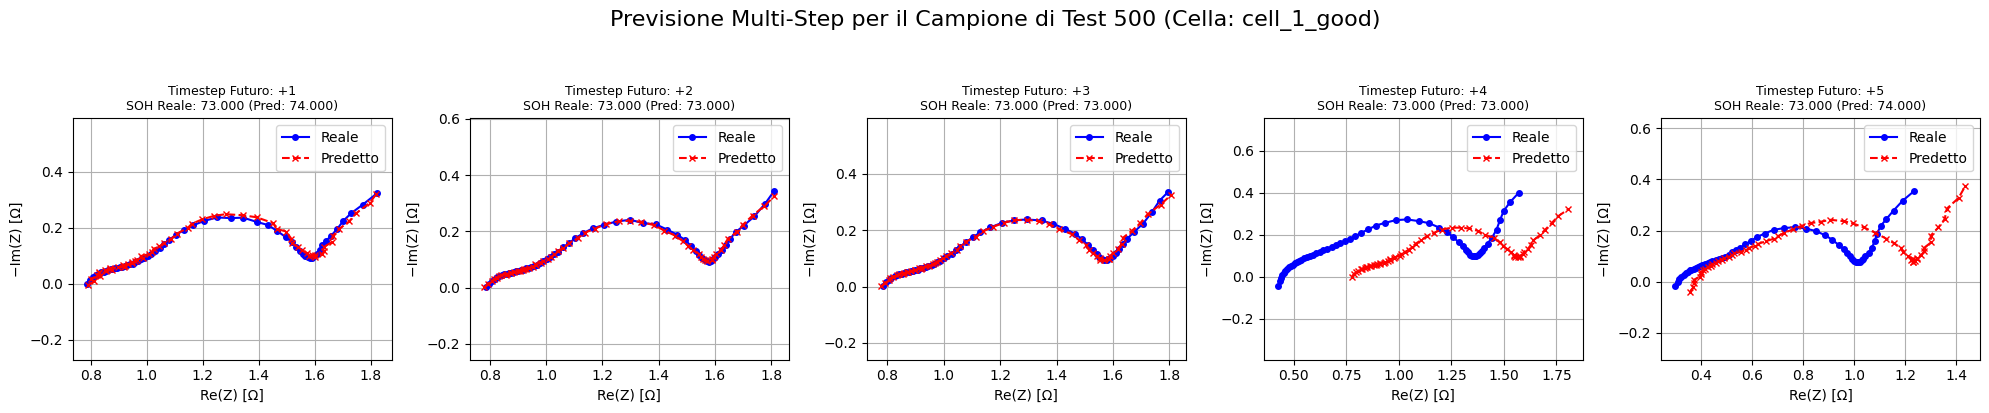

In [138]:
scalers_per_cell = load("scalers_per_cell.joblib")

print_eis_predictions(
    model=model,
    X_test_enc=X_test_enc,
    X_test_dec=X_test_dec,
    y_true_norm=y_test,
    scalers=scalers_per_cell,
    cell_ids_test=cell_ids_test, 
    index=500
)

In [127]:
model = EncoderDecoderTransformer(
    seq_len_in=SEQ_LEN_IN,
    seq_len_out=SEQ_LEN_OUT,
    num_features_in=NUM_FEATURES_IN,
    num_features_out=NUM_FEATURES_OUT,
    d_model=128,
    num_heads=6,
    ff_dim=256,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dropout=0.2
)

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4), loss="mean_squared_error")


# L'input è una lista di due tensori: [encoder_input, decoder_input]
history = model.fit(
    [X_train_enc, X_train_dec], y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([X_val_enc, X_val_dec], y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            start_from_epoch=5
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=PATIENCE//4,
            min_lr=1e-7,
            verbose=1
        )
    ]
)

Epoch 1/1000


2025-11-05 15:58:00.574102: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-05 15:58:00.574195: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-05 15:58:00.574231: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-05 15:58:00.574253: I external/l

102/102 ━━━━━━━━━━━━━━━━━━━━ 53s 62ms/step - loss: 1.3007 - val_loss: 0.3705 - learning_rate: 1.0000e-04
Epoch 2/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.6081 - val_loss: 0.3134 - learning_rate: 1.0000e-04
Epoch 3/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.4920 - val_loss: 0.2942 - learning_rate: 1.0000e-04
Epoch 4/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.4381 - val_loss: 0.2864 - learning_rate: 1.0000e-04
Epoch 5/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.4087 - val_loss: 0.2839 - learning_rate: 1.0000e-04
Epoch 6/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3884 - val_loss: 0.2826 - learning_rate: 1.0000e-04
Epoch 7/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3749 - val_loss: 0.2695 - learning_rate: 1.0000e-04
Epoch 8/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3654 - val_loss: 0.2718 - learning_rate: 1.0000e-04
Epoch 9/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.3545 - val_

In [ ]:
model.save("model_mse_multi_cell.keras")

In [131]:
scalers_per_cell = load("scalers_per_cell.joblib")

unique_cells_in_test = np.unique(cell_ids_test)
all_metrics_per_cell = {}

for cell_id in unique_cells_in_test:
    metrics = evaluate_model_per_cell(
        model,
        X_test_enc,
        X_test_dec,
        y_test,
        scalers=scalers_per_cell,
        cell_ids_test=cell_ids_test,
        cell_id_to_evaluate=cell_id
    )
    if metrics:
        all_metrics_per_cell[cell_id] = metrics

--- Inizio Valutazione Specifica per 'cella_1_sorted' ---
Esecuzione previsioni su 640 campioni per 'cella_1_sorted'...

--- RISULTATI PER 'cella_1_sorted' ---
  soh            : R2=0.9198, MSE=1.6772, MAE=0.9453
  impedance_real : R2=0.8923, MSE=0.0151, MAE=0.0628
  impedance_imag : R2=0.4874, MSE=0.0064, MAE=0.0239
--- Inizio Valutazione Specifica per 'cella_2_sorted' ---
Esecuzione previsioni su 768 campioni per 'cella_2_sorted'...

--- RISULTATI PER 'cella_2_sorted' ---
  soh            : R2=0.9758, MSE=1.0159, MAE=0.7794
  impedance_real : R2=0.9378, MSE=0.0050, MAE=0.0351
  impedance_imag : R2=0.6705, MSE=0.0020, MAE=0.0142
--- Inizio Valutazione Specifica per 'cella_5_sorted' ---
Esecuzione previsioni su 128 campioni per 'cella_5_sorted'...

--- RISULTATI PER 'cella_5_sorted' ---
  soh            : R2=-202.4948, MSE=50.4266, MAE=7.0516
  impedance_real : R2=0.7348, MSE=0.0359, MAE=0.1001
  impedance_imag : R2=0.0313, MSE=0.0191, MAE=0.0559


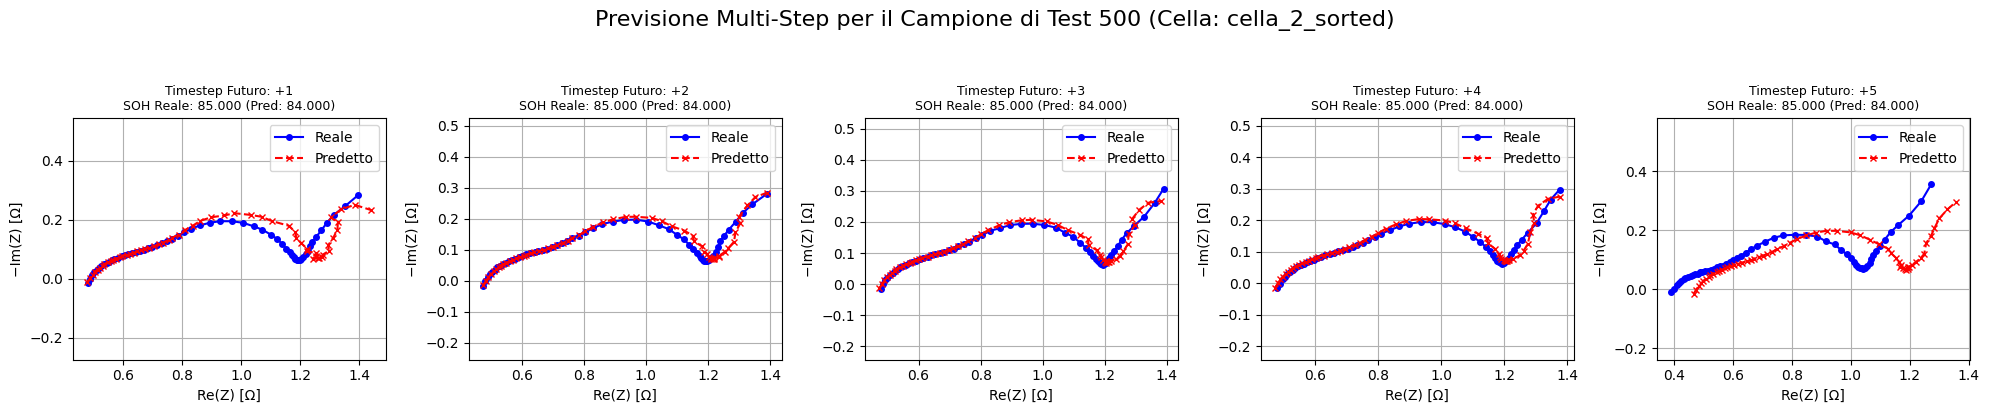

In [134]:
scalers_per_cell = load("scalers_per_cell.joblib")

print_eis_predictions(
    model=model,
    X_test_enc=X_test_enc,
    X_test_dec=X_test_dec,
    y_true_norm=y_test,
    scalers=scalers_per_cell,
    cell_ids_test=cell_ids_test, 
    index=500
)

In [ ]:
model = tf.keras.models.load_model(
    "model_mse_multi_cell.keras"
)


## LSTM

In [49]:
import numpy as np

def scheduled_sampling_batch(model, X_enc, X_dec, y_true, teacher_ratio):
    """
    Genera una versione modificata di X_dec per scheduled sampling:
    mescola i dati reali (teacher forcing) con le predizioni del modello.
    """
    batch_size = X_enc.shape[0]
    seq_len_out = X_dec.shape[1]

    # Predizione attuale del modello
    y_pred = model.predict([X_enc, X_dec], verbose=0)

    # Maschera casuale (True = usa dati reali)
    mask = np.random.rand(batch_size, seq_len_out, 1) < teacher_ratio

    # Combina le due sorgenti
    X_dec_mod = np.where(mask, X_dec, y_pred)
    return X_dec_mod


In [50]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable(package="Custom")
class AttentionLayer(layers.Layer):
    """Luong-style dot-product attention"""

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, query, values):
        # query: (batch, seq_len_dec, latent_dim)
        # values: (batch, seq_len_enc, latent_dim)
        score = tf.matmul(query, values, transpose_b=True)  # (batch, seq_len_dec, seq_len_enc)
        attention_weights = tf.nn.softmax(score, axis=-1)   # softmax sulle colonne (encoder)
        context = tf.matmul(attention_weights, values)       # (batch, seq_len_dec, latent_dim)
        return context, attention_weights

    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        return config


def build_lstm_attention_seq2seq(seq_len_in, seq_len_out,
                                 num_features_in, num_features_out,
                                 latent_dim=256, dropout=0.3):
    """
    LSTM seq2seq con attenzione (Luong-style)
    """
    # --- INPUTS ---
    encoder_inputs = layers.Input(shape=(seq_len_in, num_features_in))
    decoder_inputs = layers.Input(shape=(seq_len_out, num_features_out))

    # --- ENCODER ---
    encoder_lstm = layers.Bidirectional(
        layers.LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout)
    )
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_inputs)
    state_h = layers.Concatenate()([forward_h, backward_h])
    state_c = layers.Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]

    # --- DECODER ---
    decoder_lstm = layers.LSTM(latent_dim * 2, return_sequences=True, return_state=True, dropout=dropout)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    # --- ATTENTION ---
    attention = AttentionLayer()
    context_vector, attn_weights = attention(decoder_outputs, encoder_outputs)

    # Combina contesto + decoder output
    combined = layers.Concatenate(axis=-1)([decoder_outputs, context_vector])
    combined = layers.LayerNormalization()(combined)

    # --- OUTPUT ---
    dense = layers.TimeDistributed(layers.Dense(256, activation='relu'))(combined)
    dense = layers.Dropout(dropout)(dense)
    outputs = layers.TimeDistributed(layers.Dense(num_features_out, activation='linear'))(dense)

    model = Model([encoder_inputs, decoder_inputs], outputs)
    return model


In [51]:
model = build_lstm_attention_seq2seq(
    seq_len_in=SEQ_LEN_IN,
    seq_len_out=SEQ_LEN_OUT,
    num_features_in=NUM_FEATURES_IN,
    num_features_out=NUM_FEATURES_OUT,
    latent_dim=128,
    dropout=0.3
)

optimizer = tf.keras.optimizers.Adam(1e-4)
model.compile(optimizer=optimizer, loss="mean_absolute_error")

teacher_start = 1.0   
teacher_end = 0.2 
epochs = EPOCHS

for epoch in range(100):
    decay_rate = 15.0  
    progress = epoch / epochs
    teacher_ratio = teacher_end + (teacher_start - teacher_end) * np.exp(-decay_rate * progress)
    teacher_ratio = max(teacher_end, teacher_ratio)

    print(f"\nEpoch {epoch+1}/{epochs} — teacher_ratio = {teacher_ratio:.3f}")

    X_train_dec_mod = scheduled_sampling_batch(model, X_train_enc, X_train_dec, y_train, teacher_ratio)

    model.fit(
        [X_train_enc, X_train_dec_mod], y_train,
        validation_data=([X_val_enc, X_val_dec], y_val),
        epochs=1,
        batch_size=BATCH_SIZE,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True, min_delta=0.0005),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10, min_lr=1e-6, min_delta=0.001)
        ],
        verbose=1
    )




Epoch 1/1000 — teacher_ratio = 1.000
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.9537 - val_loss: 0.6554 - learning_rate: 1.0000e-04

Epoch 2/1000 — teacher_ratio = 0.988
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7290 - val_loss: 0.5889 - learning_rate: 1.0000e-04

Epoch 3/1000 — teacher_ratio = 0.976
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6467 - val_loss: 0.5345 - learning_rate: 1.0000e-04

Epoch 4/1000 — teacher_ratio = 0.965
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5981 - val_loss: 0.4893 - learning_rate: 1.0000e-04

Epoch 5/1000 — teacher_ratio = 0.953
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5588 - val_loss: 0.4533 - learning_rate: 1.0000e-04

Epoch 6/1000 — teacher_ratio = 0.942
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5253 - val_loss: 0.4153 - learning_rate: 1.0000e-04

Epoch 7/1000 — teacher_ratio = 0.931
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4950 - val_loss: 0.3916 - learning_rate: 1.0000e-04

Epoch 8/1000 — teac

In [52]:
scalers_per_cell = load("scalers_per_cell.joblib")

unique_cells_in_test = np.unique(cell_ids_test)
all_metrics_per_cell = {}

for cell_id in unique_cells_in_test:
    metrics = evaluate_model_per_cell(
        model,
        X_test_enc,
        X_test_dec,
        y_test,
        scalers=scalers_per_cell,
        cell_ids_test=cell_ids_test,
        cell_id_to_evaluate=cell_id
    )
    if metrics:
        all_metrics_per_cell[cell_id] = metrics

--- Inizio Valutazione Specifica per 'cell_1_good' ---
Esecuzione previsioni su 384 campioni per 'cell_1_good'...

--- RISULTATI PER 'cell_1_good' ---
  soh            : R2=0.9634, MSE=5.7182, MAE=1.8141
  impedance_real : R2=0.9106, MSE=0.0210, MAE=0.0669
  impedance_imag : R2=0.9522, MSE=0.0005, MAE=0.0086
--- Inizio Valutazione Specifica per 'cell_2_good' ---
Esecuzione previsioni su 448 campioni per 'cell_2_good'...

--- RISULTATI PER 'cell_2_good' ---
  soh            : R2=0.9296, MSE=3.5500, MAE=1.0625
  impedance_real : R2=0.9709, MSE=0.0024, MAE=0.0214
  impedance_imag : R2=0.9750, MSE=0.0001, MAE=0.0045
--- Inizio Valutazione Specifica per 'cell_5_good' ---
Esecuzione previsioni su 64 campioni per 'cell_5_good'...

--- RISULTATI PER 'cell_5_good' ---
  soh            : R2=0.0000, MSE=9.0062, MAE=2.5375
  impedance_real : R2=0.9895, MSE=0.0013, MAE=0.0218
  impedance_imag : R2=0.9550, MSE=0.0003, MAE=0.0084


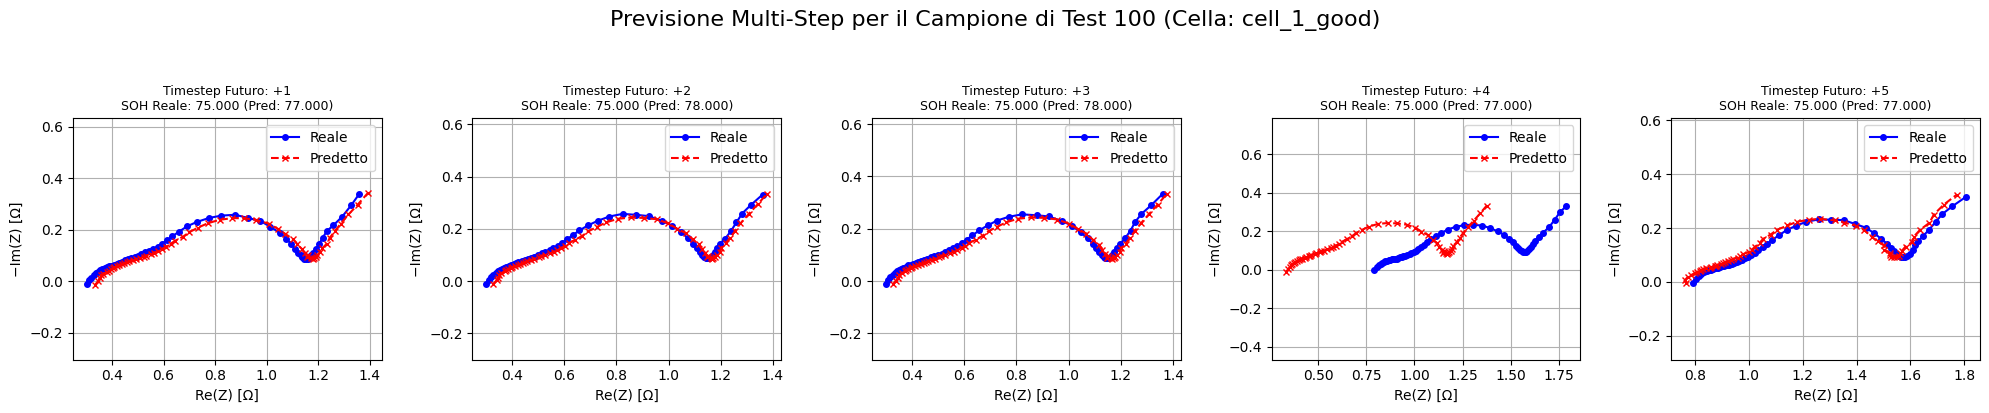

In [53]:
print_eis_predictions(
    model=model,
    X_test_enc=X_test_enc,
    X_test_dec=X_test_dec,
    y_true_norm=y_test,
    scalers=scalers_per_cell,
    cell_ids_test=cell_ids_test, 
    index=100
)

In [54]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 121)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 128,      │    256,000 │ input_layer[0][0] │
│ (Bidirectional)     │ 256), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5, 121)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 5, 256),  │    387,072 │ input_layer_1[0]… │
│                     │ (None, 256),      │            │ concatenate[0][0… │
│                     │ (None, 256)]      │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, 5, 256),  │          0 │ lstm_1[0][0],     │
│ (AttentionLayer)    │ (None, 5, 128)]   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 5, 512)    │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 512)    │      1,024 │ concatenate_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 5, 256)    │    131,328 │ layer_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 5, 256)    │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 5, 121)    │     31,097 │ dropout[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,419,565 (9.23 MB)

 Trainable params: 806,521 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,613,044 (6.15 MB)

In [ ]:
model.save("lstm_sampling.keras")

In [ ]:
model = tf.keras.models.load_model("lstm_sampling.keras")